In [499]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
folder_path_1 = "/Users/rohinpalsule/Documents/GitHub/GW_MST/GWR_data/batch01"
folder_path_2 = "/Users/rohinpalsule/Documents/GitHub/GW_MST/GWR_data/batch02"
df_rep_list = []

# Iterate through all CSV files in the folder
for file in os.listdir(folder_path_1):
    if file.endswith(".csv"):  # Check if the file is a CSV
        file_path = os.path.join(folder_path_1, file)
        print(f"Reading: {file}")
        try:
            df_individual = pd.read_csv(file_path, on_bad_lines='skip')
            df_rep_list.append(df_individual)
        except Exception as e:
            print(f"Error reading {file}: {e}")
for file in os.listdir(folder_path_2):
    if file.endswith(".csv"):  # Check if the file is a CSV
        file_path = os.path.join(folder_path_2, file)
        print(f"Reading: {file}")
        try:
            df_individual = pd.read_csv(file_path, on_bad_lines='skip')
            df_rep_list.append(df_individual)
        except Exception as e:
            print(f"Error reading {file}: {e}")
# Concatenate all DataFrames
df_rep = pd.concat(df_rep_list, ignore_index=True)
df_rep['partid'] = df_rep['responses'].str.replace('{worker_id:',"").str.replace('}', '')
df_rep['partid'] = df_rep['partid'].ffill()
df_rep['sequence']=df_rep['sequence'].ffill()

Reading: final_S_5faefcc22be93b11829e84df.csv
Reading: final_S_5b09f4f1d282ff00015b536d.csv
Reading: final_S_560ce65601c38a0012769e20.csv
Reading: final_S_60ddfe929fff846f04cd2c95.csv
Reading: final_S_5e34325430e5263f0bebb32d.csv
Reading: final_S_661045b87d3e3a9bda51b367.csv
Reading: final_S_638476f72ab8021be345e3ac.csv
Reading: final_S_5ba5d8b960f3d50001697104.csv
Reading: final_S_6595938bf754e3013651e556.csv
Reading: final_S_65b92135e296f28cb1a093c3.csv
Reading: final_S_5fc50bb38378c80ac88354ef.csv
Reading: final_S_574ce0a57fd0ec000db73aa6.csv
Reading: final_S_5e2ac2aa0038f21089a533a4.csv
Reading: final_S_5f7be1818da8861e3c3fcae8.csv
Reading: final_S_663bc31529719b8501c52820.csv
Reading: final_S_5c03975936230300012948ba.csv
Reading: final_S_56d39b96da2aaa000dab6178.csv
Reading: final_S_5fd955152dc9172302e1d605.csv
Reading: final_S_5dccb82a76eab294aa4837ff.csv
Reading: final_S_5b5c3b266b25590001778ea1.csv
Reading: final_S_644b1e452a0061d713dcbf4a.csv
Reading: final_S_54e32a60fdf99b3ea

In [525]:
df_rep

,rt,responses,trial_type,time_elapsed,sequence,stimulus,graphorder,button_pressed,response,key_press,...,detour_trial,linedressed_detor,problems,smooth,distraction,strategies,easier,similar,comments,partid
0,13333.1,{worker_id:5faefcc22be93b11829e84df},id_enter,13335,interleaved,replication,GW/hanover.png; GW/peoria.png; GW/newhope.png;...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5faefcc22be93b11829e84df
1,5272.9,NaN,fullscreen,18612,interleaved,fullscreen,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5faefcc22be93b11829e84df
2,26778.8,NaN,intro_1,45394,interleaved,instruct,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5faefcc22be93b11829e84df
3,22106.1,NaN,intro_2,67502,interleaved,instruct,NaN,1.0,Next,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5faefcc22be93b11829e84df
4,12228.8,NaN,intro_3,79733,interleaved,instruct,NaN,1.0,Next,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5faefcc22be93b11829e84df
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34196,6086.0,NaN,intro_1,4261631,blocked,instruct,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,663e5cf112f5d047cf5c9fad
34197,5846.3,NaN,intro_2,4267480,blocked,instruct,NaN,1.0,Next,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,663e5cf112f5d047cf5c9fad
34198,1581.6,NaN,intro_3,4269065,blocked,instruct,NaN,1.0,Next,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,663e5cf112f5d047cf5c9fad
34199,NaN,NaN,Graph Reconstruction,4379154,blocked,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,663e5cf112f5d047cf5c9fad


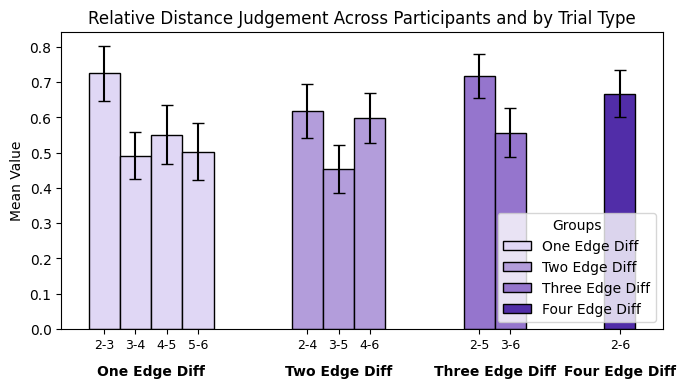

In [500]:
direct_df = df_rep[df_rep['trial_type']=='directmemory_phase']
direct_df = direct_df.loc[:, ~direct_df.isna().all()]
direct_df = direct_df.drop(columns=['time_elapsed','cumulative_accuracy','weighted_accuracy']).reset_index(drop='index')
direct_df = direct_df.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
direct_df = direct_df.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
direct_df = direct_df.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

shortest_df = df_rep[df_rep['trial_type']=='shortestpath_phase']
shortest_df = shortest_df.loc[:, ~shortest_df.isna().all()]
shortest_df = shortest_df.drop(columns=['time_elapsed','cumulative_accuracy']).reset_index(drop='index')
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

# Step 1: Combine stimulus and stimulus_correct into one long-form df with accuracy
long_direct_df = pd.concat([
    direct_df[['partid', 'stimulus', 'accuracy']].rename(columns={'stimulus': 'city'}),
    direct_df[['partid', 'stimulus_correct', 'accuracy']].rename(columns={'stimulus_correct': 'city'})
])

# Step 2: Group by participant and city, then check if all accuracies were 1.0
city_accuracy = long_direct_df.groupby(['partid', 'city'])['accuracy'].agg(lambda x: (x == 1.0).all()).reset_index()
city_accuracy = city_accuracy[city_accuracy['accuracy']]  # Keep only 100% accurate cities
city_accuracy = city_accuracy.drop(columns='accuracy')     # Just keep partid and city

# Step 3: Filter shortest_df by keeping only rows where both cities were 100% accurate
filtered_shortest_df = shortest_df[
    shortest_df.apply(
        lambda row: (
            (row['partid'], row['stimulus']) in city_accuracy.set_index(['partid', 'city']).index and
            (row['partid'], row['stimulus_correct']) in city_accuracy.set_index(['partid', 'city']).index
        ),
        axis=1
    )
]
grouped_shortest = filtered_shortest_df.groupby(['partid','specific_pairs'])['accuracy'].agg(['mean','count']).reset_index()

twothree = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Three Edge']
threefour = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Four Edge']
fourfive = grouped_shortest[grouped_shortest['specific_pairs']=='Four Edge Five Edge']
fivesix = grouped_shortest[grouped_shortest['specific_pairs']=='Five Edge Six Edge']

twofour = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Four Edge']
threefive = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Five Edge']
foursix = grouped_shortest[grouped_shortest['specific_pairs']=='Four Edge Six Edge']

twofive = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Five Edge']
threesix = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Six Edge']

twosix = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Six Edge']

# --- Sample Data ---
group_labels = ['One Edge Diff', 'Two Edge Diff', 'Three Edge Diff', 'Four Edge Diff']

# Generate dummy data
heights = [
    [twothree['mean'].mean(), threefour['mean'].mean(), fourfive['mean'].mean(), fivesix['mean'].mean()],  # One diff
    [twofour['mean'].mean(), threefive['mean'].mean(), foursix['mean'].mean()],       # Two diff
    [twofive['mean'].mean(), threesix['mean'].mean()],            # Three diff
    [twosix['mean'].mean()]                  # Four diff
]

errors = [
    [twothree['mean'].sem(), threefour['mean'].sem(), fourfive['mean'].sem(), fivesix['mean'].sem()],  # One diff
    [twofour['mean'].sem(), threefive['mean'].sem(), foursix['mean'].sem()],       # Two diff
    [twofive['mean'].sem(), threesix['mean'].sem()],            # Three diff
    [twosix['mean'].sem()]                  # Four diff
]

bar_labels = [
    ['2-3', '3-4', '4-5', '5-6'],     # One diff
    ['2-4', '3-5', '4-6'],          # Two diff
    ['2-5', '3-6'],               # Three diff
    ['2-6']                    # Four diff
]

bar_width = 0.2
group_gap = 0.5

fig, ax = plt.subplots(figsize=(7, 4))

x_offset = 0
all_positions = []
all_labels = []
group_centers = []
# Optional: participant-level means
participant_means = shortest_df.groupby(['partid', 'specific_pairs'])['accuracy'].mean().reset_index()

# Then Tukey test on those
# tukey = pairwise_tukeyhsd(endog=participant_means['accuracy'],
#                         groups=participant_means['specific_pairs'],
#                         alpha=0.05)
# print(tukey.summary())
# Define blue color shades (lightest to darkest)
group_colors = ['#e0d7f5', '#b39ddb', '#9575cd', '#512da8']
# group_colors = ['#cce5ff', '#66b3ff', '#1f78b4', '#08306b']  # Adjust or expand as needed

for i, (group, group_err, labels) in enumerate(zip(heights, errors, bar_labels)):
    num_bars = len(group)
    positions = np.arange(num_bars) * bar_width + x_offset
    ax.bar(positions, group, yerr=group_err, capsize=4, width=bar_width,
        edgecolor='black', label=group_labels[i], color=group_colors[i])
    
    # Store positions and labels for x-ticks
    all_positions.extend(positions)
    all_labels.extend(labels)
    
    # Calculate center of group for big group label
    group_centers.append(positions.mean())
    
    # Update x offset for next group
    x_offset = positions[-1] + bar_width + group_gap

# Set small bar labels as x-tick labels
ax.set_xticks(all_positions)
ax.set_xticklabels(all_labels, fontsize=9)

# Add big group labels below
for center, label in zip(group_centers, group_labels):
    ax.text(center, -0.1, label, ha='center', va='top', fontsize=10,
            fontweight='bold', transform=ax.transData)
# --- Formatting ---
ax.legend(title='Groups')
ax.set_ylabel('Mean Value')
ax.set_title(f'Relative Distance Judgement Across Participants and by Trial Type')
plt.tight_layout()
plt.show()

/var/folders/80/x27szhys5v384yshvf0yrws40000gn/T/ipykernel_97812/2940166402.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rep_block['rt'] = pd.to_numeric(df_rep_block['rt'], errors='coerce')
/var/folders/80/x27szhys5v384yshvf0yrws40000gn/T/ipykernel_97812/2940166402.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rep_int['rt'] = pd.to_numeric(df_rep_int['rt'], errors='coerce')


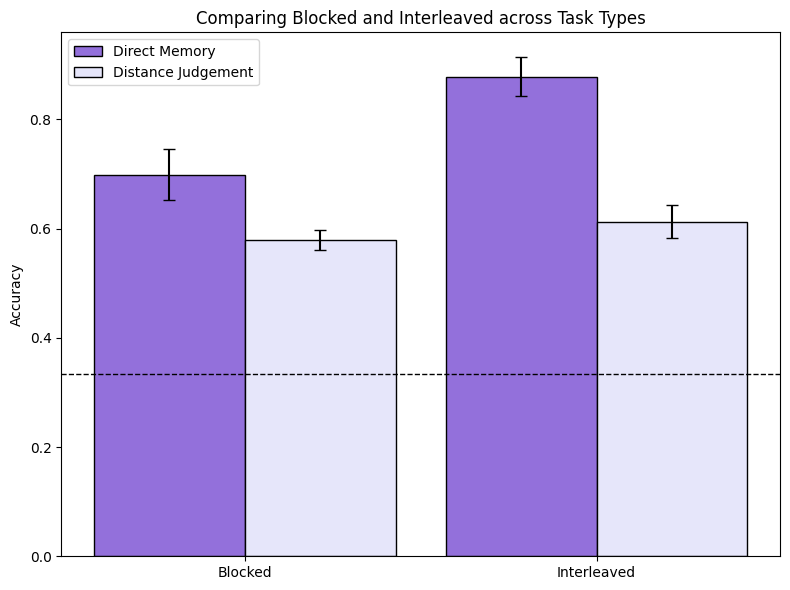

In [501]:
from matplotlib.patches import Patch
def get_chosen_city(row):
    if  row['key_press'] == 49:
        return row['stimulus_down_left']
    elif  row['key_press'] == 50:
        return row['stimulus_down_mid']
    elif  row['key_press'] == 51:
        return row['stimulus_down_right']
    else: return pd.NA

def get_wrong_distance(row):
    if pd.isna(row['stimulus_selected']):
        return pd.NA
    elif row['stimulus_selected'] == row['stimulus_short']:
        return 'close'
    elif row['stimulus_selected'] == row['stimulus_far']:
        return 'far'
    elif row['stimulus_selected'] == row['stimulus_correct']:
        return 'correct'
    else: return pd.NA

def get_weighted_correct(row):
    if pd.isna(row['wrong_distance']):
        return pd.NA
    elif row['wrong_distance'] == 'close':
        return 0.5
    elif row['wrong_distance'] == 'far':
        return 0
    elif row['wrong_distance'] == 'correct':
        return 1
    else: return pd.NA

# df_flights = df_flights[~df_flights['stimulus'].isna()]
df_rep_block = df_rep[df_rep['sequence']=='blocked']
# df_rep_block = df_rep_block[~df_rep_block['rt'].isna()]
df_rep_block
direct_df_replication = df_rep_block[df_rep_block['trial_type']=='directmemory_phase']
direct_df_replication = direct_df_replication.loc[:, ~direct_df_replication.isna().all()]
direct_df_replication = direct_df_replication.drop(columns=['time_elapsed','cumulative_accuracy','weighted_accuracy','missedtrial']).reset_index(drop='index')
direct_df_replication = direct_df_replication.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
direct_df_replication = direct_df_replication.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
direct_df_replication = direct_df_replication.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

# for id in bad_partid:
#     direct_df = direct_df[direct_df['partid'] != id]

direct_df_replication['stimulus_selected'] = direct_df_replication.apply(get_chosen_city,axis=1)
direct_df_replication['wrong_distance'] = direct_df_replication.apply(get_wrong_distance,axis=1)
direct_df_replication['weighted_correct'] = direct_df_replication.apply(get_weighted_correct,axis=1)
direct_df_replication['rt'] = pd.to_numeric(direct_df_replication['rt'], errors='coerce')
direct_df_replication = direct_df_replication[(direct_df_replication['rt']>400)&(direct_df_replication['rt']<5000)]

direct_block = direct_df_replication.groupby('partid')['accuracy'].mean()
direct_block
df_rep_block['rt'] = pd.to_numeric(df_rep_block['rt'], errors='coerce')
df_short_block_ungrouped = df_rep_block[(df_rep_block['trial_type']=='shortestpath_phase') & df_rep_block['stimulus'].notna() & (df_rep_block['rt'] > 400) & (df_rep_block['rt'] < 5000)]
df_short_block = df_short_block_ungrouped.groupby('partid')['accuracy'].mean()
###
# df_rep = df_rep[~df_rep['stimulus'].isna()]
df_rep_int = df_rep[df_rep['sequence']=='interleaved']
# df_rep_int = df_rep_int[~df_rep_int['rt'].isna()].reset_index(drop='index')
direct_df_replication = df_rep_int[df_rep_int['trial_type']=='directmemory_phase']
direct_df_replication = direct_df_replication.loc[:, ~direct_df_replication.isna().all()]
direct_df_replication = direct_df_replication.drop(columns=['time_elapsed','cumulative_accuracy','weighted_accuracy']).reset_index(drop='index')
direct_df_replication = direct_df_replication.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
direct_df_replication = direct_df_replication.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
direct_df_replication = direct_df_replication.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

# for id in bad_partid:
#     direct_df = direct_df[direct_df['partid'] != id]

direct_df_replication['stimulus_selected'] = direct_df_replication.apply(get_chosen_city,axis=1)
direct_df_replication['wrong_distance'] = direct_df_replication.apply(get_wrong_distance,axis=1)
direct_df_replication['weighted_correct'] = direct_df_replication.apply(get_weighted_correct,axis=1)
# direct_df_replication = direct_df_replication[(direct_df_replication['rt']>400)&(direct_df_replication['rt']<500000)]

direct_inter = direct_df_replication.groupby('partid')['accuracy'].mean()
direct_inter
df_rep_int['rt'] = pd.to_numeric(df_rep_int['rt'], errors='coerce')
df_short_inter_ungrouped = df_rep_int[(df_rep_int['trial_type']=='shortestpath_phase') & df_rep_int['stimulus'].notna() & (df_rep_int['rt'] > 400) & (df_rep_int['rt'] < 5000)]
df_short_inter = df_short_inter_ungrouped.groupby('partid')['accuracy'].mean()

plt.figure(figsize=(8,6))
plt.bar(x=0.3,height= direct_block.mean(),yerr=direct_block.sem(),capsize=4,color='mediumpurple',width=0.3,edgecolor='black',label='Direct Memory')
plt.bar(x=.6,height= df_short_block.mean(),yerr=df_short_block.sem(),capsize=4,color='lavender',width=0.3,edgecolor='black',label='Distance Judgement')
plt.bar(x=1,height= direct_inter.mean(),yerr=direct_inter.sem(),capsize=4,color='mediumpurple',width=0.3,edgecolor='black')
plt.bar(x=1.3,height= df_short_inter.mean(),yerr=df_short_inter.sem(),capsize=4,color='lavender',width=0.3,edgecolor='black')


plt.xticks([0.45,1.15],['Blocked','Interleaved'])
plt.ylabel( "Accuracy")
plt.title(f"Comparing Blocked and Interleaved across Task Types")
plt.legend()
plt.axhline(y=0.3333, color='black', linestyle='--', linewidth=1)
plt.grid(False)
plt.tight_layout()
plt.show()


In [530]:
df_rep_int[df_rep_int['trial_type']=='directmemory_phase'].dropna(axis=1,how='all').to_csv("interleaved_direct_memory.csv")
df_rep_int[df_rep_int['trial_type']=='shortestpath_phase'].dropna(axis=1,how='all').to_csv("interleaved_relative_distance_judgement.csv")
df_rep_block[df_rep_block['trial_type']=='directmemory_phase'].dropna(axis=1,how='all').to_csv("blocked_direct_memory.csv")
df_rep_block[df_rep_block['trial_type']=='shortestpath_phase'].dropna(axis=1,how='all').to_csv("blocked_relative_distance_judgement.csv")

In [524]:
(df_rep[df_rep['sequence']=='blocked']['rt']).to_csv('test.csv')

In [502]:
direct_df_replication['rt']

0      2541.1
1      1934.5
2      2211.0
3      2466.0
4      1382.7
        ...  
603    1278.5
604    2024.5
605    2102.0
606    2352.1
607    3931.9
Name: rt, Length: 608, dtype: object

In [503]:
from scipy.stats import ttest_ind

# Blocked condition
t_blocked, p_blocked = ttest_ind(direct_block,df_short_block , equal_var=False)  # Welch's t-test
print(f"Blocked Task Type: t = {t_blocked:.3f}, p = {p_blocked:.3f}")

# Interleaved condition
t_interleaved, p_interleaved = ttest_ind(direct_inter, df_short_inter, equal_var=False)
print(f"Interleaved Task Type: t = {t_interleaved:.3f}, p = {p_interleaved:.3f}")

Blocked Task Type: t = 2.402, p = 0.026
Interleaved Task Type: t = 5.675, p = 0.000


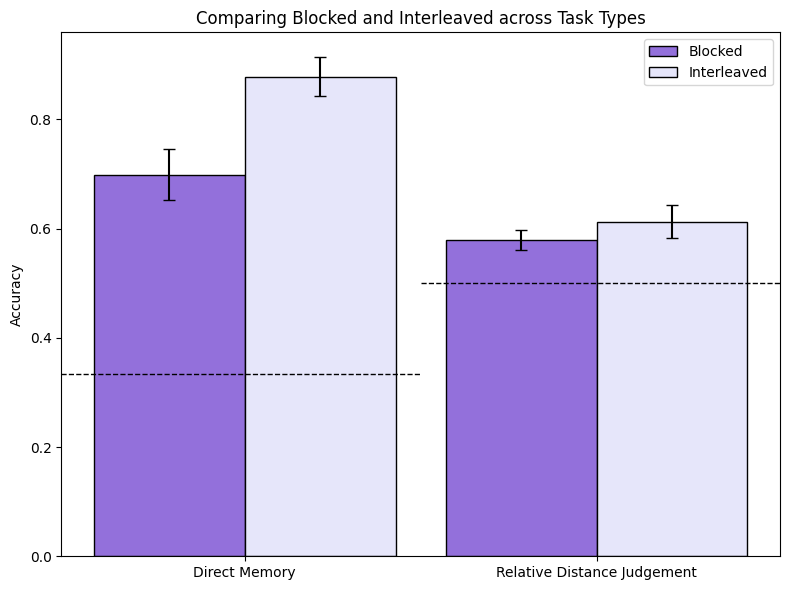

In [504]:
plt.figure(figsize=(8,6))
plt.bar(x=0.3,height= direct_block.mean(),yerr=direct_block.sem(),capsize=4,color='mediumpurple',width=0.3,edgecolor='black',label='Blocked')
plt.bar(x=.6,height= direct_inter.mean(),yerr=direct_inter.sem(),capsize=4,color='lavender',width=0.3,edgecolor='black',label='Interleaved')
plt.bar(x=1,height= df_short_block.mean(),yerr=df_short_block.sem(),capsize=4,color='mediumpurple',width=0.3,edgecolor='black')
plt.bar(x=1.3,height= df_short_inter.mean(),yerr=df_short_inter.sem(),capsize=4,color='lavender',width=0.3,edgecolor='black')


plt.xticks([0.45,1.15],['Direct Memory','Relative Distance Judgement'])
plt.ylabel( "Accuracy")
plt.title(f"Comparing Blocked and Interleaved across Task Types")
plt.legend()
plt.axhline(y=0.3333, color='black', linestyle='--', linewidth=1, xmin=0, xmax=0.5)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1, xmin=0.5, xmax=1)
plt.grid(False)
plt.tight_layout()
plt.show()

In [505]:
from scipy.stats import ttest_ind

# Blocked condition
t_blocked, p_blocked = ttest_ind(direct_block, direct_inter, equal_var=False)  # Welch's t-test
print(f"Direct Schedules: t = {t_blocked:.3f}, p = {p_blocked:.3f}")

# Interleaved condition
t_interleaved, p_interleaved = ttest_ind(df_short_block, df_short_inter, equal_var=False)
print(f"RDJ Schedules: t = {t_interleaved:.3f}, p = {p_interleaved:.3f}")

Direct Schedules: t = -3.084, p = 0.004
RDJ Schedules: t = -0.940, p = 0.355


In [533]:
df_rep.to_csv("/Users/rohinpalsule/Downloads/compiled_raw_df.csv",index=False)


In [506]:
print("Blocked Participants: ", direct_block.count())
print("Interleaved Participants: ", df_short_inter.count())

Blocked Participants:  16
Interleaved Participants:  19


In [507]:
print("Blocked Direct Memory: \n", round(direct_block.agg(['mean','sem']),3))
print("\nBlocked Shortest Path: \n", round(df_short_block.agg(['mean','sem']),3))
print("\nInterleaved Direct Memory:  \n", round(direct_inter.agg(['mean','sem']),3))
print("\nInterleaved Shortest Path:  \n", round(df_short_inter.agg(['mean','sem']),3))

Blocked Direct Memory: 
 mean    0.699
sem     0.046
Name: accuracy, dtype: float64

Blocked Shortest Path: 
 mean    0.579
sem     0.018
Name: accuracy, dtype: float64

Interleaved Direct Memory:  
 mean    0.878
sem     0.035
Name: accuracy, dtype: float64

Interleaved Shortest Path:  
 mean    0.613
sem     0.031
Name: accuracy, dtype: float64


In [508]:
df_short_block_ungrouped.groupby(['partid','condition'])['accuracy'].mean().reset_index()

,partid,condition,accuracy
0,560ce65601c38a0012769e20,Four Edge Diff,0.416667
1,560ce65601c38a0012769e20,One Edge Diff,0.666667
2,560ce65601c38a0012769e20,Three Edge Diff,0.666667
3,560ce65601c38a0012769e20,Two Edge Diff,0.652174
4,56d39b96da2aaa000dab6178,Four Edge Diff,0.833333
...,...,...,...
59,663e5cf112f5d047cf5c9fad,Two Edge Diff,0.375000
60,6841f4329a9deda70eae9ed4,Four Edge Diff,0.818182
61,6841f4329a9deda70eae9ed4,One Edge Diff,0.333333
62,6841f4329a9deda70eae9ed4,Three Edge Diff,0.333333


In [509]:
high_mst = ['610064cd25c1c2ed6fa9b925','60ddfe929fff846f04cd2c95',
 '63e5872c841f61b1309e1d18','62b055b8af4eda974466ad0d',
 '5faefcc22be93b11829e84df','5ac16e870527ba0001c1f27e',
 '67c37b3de7f32fe80ac6e915','668180f26a3b162091510589',
 '5e34325430e5263f0bebb32d','64aff8a2c8ddc83286a349c3',
 '614f571879ee135c5a579e08','663bc31529719b8501c52820',
 '5f7be1818da8861e3c3fcae8','5b5c3b266b25590001778ea1',
 '5fd955152dc9172302e1d605','663e5cf112f5d047cf5c9fad',
 '5b22d2c260c40e000103b157','6595a5cbe675d0fc372344b9',
 '65fb1a5882c2d4825dab5e81','64cf9d38c6677895238e9ef5',
 '5b3e2334cdb4ce0001d93c51','6604cdce9c02df4997ec8b68',
 '663a5cc00a9319ae2817cae1','65d563ecf8df20ade2f17888',
 '60e36e6ecb9f00e7b4dab92e','66b22d654efb81d166b890d0',
 '67178054a368314e6afa5ed4']

low_mst = ['65639bc09216e3f40fcd1d4b', '66439c275cd3cf1ee2426935',
 '65de3f6558e2556c9250e39e', '66e0813b79955faf3b6017c3',
 '5f285dc5b09b3715fa20a14c','6595938bf754e3013651e556',
 '574ce0a57fd0ec000db73aa6','661045b87d3e3a9bda51b367',
 '666ca8f24bc3a8e75b8f6ee2','5ba5d8b960f3d50001697104',
 '638476f72ab8021be345e3ac','5f4a4da1575d605c43bef871',
 '6785c695a07c912f4f5a105d','6472a86d375de763928da935',
 '5c5f8a910edbd90001e1feda','6508adaced024f8da237ff03',
 '5fc50bb38378c80ac88354ef','63bce1f5fd754309a47160d8',
 '614f39b82ccdbdd51c76cc50','56d39b96da2aaa000dab6178',
 '644b1e452a0061d713dcbf4a','5dccb82a76eab294aa4837ff',
 '6571d671bd27124fc516adba','60bd28cc95ab27d4f4f6ada3',
 '66ff2e26065000a46d8ca996','64014527b3cff9215591758d',
 '6841f4329a9deda70eae9ed4','614e50084109bcceada6945c',
 '6654c3056acf3abb982b23ab','626976d0dfd20d6832fc92aa',
 '604bd44cc5668ba12cc9376e','67453b68053f8bb07e1df57b',
 '678c48da89c13a4a7ce47d9f','663170bb631c1b3b21b7828b',
 '66463d3560eac977430ac716','5c03975936230300012948ba',
 '66885d217777eda6f3a9b8dd','5dd33b9159b1b033ec2cf634',
 '58cab9bfc7ed3f000116e2a4','6694251bbfc3e4a246f8125a',
 '629e112d75f3665c8362ab6f','5e94fc39cc318836529fd876',
 '67062295123561f8241f65fc','6361eebd5327cc2337bd13ad',
 '54e32a60fdf99b3eae9de85b','5bb7af73dd840f0001d85935']

def mst_score(row):
    if row['partid'] in high_mst:
        return "high"
    elif row['partid'] in low_mst:
        return "low"
    else: return "NA"

blocked_accuracy = df_short_block.reset_index()
blocked_accuracy.columns = ['partid', 'short_accuracy']
blocked_accuracy['MST'] = blocked_accuracy.apply(mst_score,axis=1)
inter_accuracy = df_short_inter.reset_index()
inter_accuracy.columns = ['partid', 'short_accuracy']
inter_accuracy['MST'] = inter_accuracy.apply(mst_score,axis=1)

blocked_accuracy_conditions = df_short_block_ungrouped.groupby(['partid','condition'])['accuracy'].mean().reset_index()
blocked_accuracy_conditions.columns = ['partid', 'condition', 'short_accuracy']
blocked_accuracy_conditions['MST'] = blocked_accuracy.apply(mst_score,axis=1)
inter_accuracy_conditions = df_short_inter_ungrouped.groupby(['partid','condition'])['accuracy'].mean().reset_index()
inter_accuracy_conditions.columns = ['partid', 'condition', 'short_accuracy']
inter_accuracy_conditions['MST'] = inter_accuracy_conditions.apply(mst_score,axis=1)


blocked_accuracy

,partid,short_accuracy,MST
0,560ce65601c38a0012769e20,0.625000,NA
1,56d39b96da2aaa000dab6178,0.619048,low
2,5dccb82a76eab294aa4837ff,0.614458,low
3,5e2ac2aa0038f21089a533a4,0.545455,NA
4,5fc50bb38378c80ac88354ef,0.452381,low
5,60ddfe929fff846f04cd2c95,0.654762,high
6,626976d0dfd20d6832fc92aa,0.634146,low
7,629e112d75f3665c8362ab6f,0.649351,low
8,638476f72ab8021be345e3ac,0.518519,low
9,644b1e452a0061d713dcbf4a,0.642857,low


In [510]:
blocked_accuracy['MST'].value_counts()

MST
low     9
high    4
NA      3
Name: count, dtype: int64

In [511]:
inter_accuracy['MST'].value_counts()

MST
low     11
high     7
NA       1
Name: count, dtype: int64

In [ ]:
mst_df = pd.read_csv('/Users/rohinpalsule/Documents/GitHub/GW_MST/mst_df.csv',on_bad_lines='skip')
blocked_accuracy['idcode']=blocked_accuracy['partid']
blocked_accuracy = blocked_accuracy.merge(
    mst_df[['idcode', 'LDI','Age']],
    on='idcode',
    how='left'
).drop(columns='idcode')

inter_accuracy['idcode']=inter_accuracy['partid']
inter_accuracy = inter_accuracy.merge(
    mst_df[['idcode', 'LDI','Age']],
    on='idcode',
    how='left'
).drop(columns='idcode')

blocked_accuracy_conditions['idcode']=blocked_accuracy_conditions['partid']
blocked_accuracy_conditions = blocked_accuracy_conditions.merge(
    mst_df[['idcode', 'LDI','Age']],
    on='idcode',
    how='left'
).drop(columns='idcode')

inter_accuracy_conditions['idcode']=inter_accuracy_conditions['partid']
inter_accuracy_conditions = inter_accuracy_conditions.merge(
    mst_df[['idcode', 'LDI','Age']],
    on='idcode',
    how='left'
).drop(columns='idcode')


,partid,condition,short_accuracy,MST,LDI,Age
0,54e32a60fdf99b3eae9de85b,Four Edge Diff,0.500000,low,0.313,41
1,54e32a60fdf99b3eae9de85b,One Edge Diff,0.333333,low,0.313,41
2,54e32a60fdf99b3eae9de85b,Three Edge Diff,0.458333,low,0.313,41
3,54e32a60fdf99b3eae9de85b,Two Edge Diff,0.625000,low,0.313,41
4,574ce0a57fd0ec000db73aa6,Four Edge Diff,0.916667,low,0.297,74
...,...,...,...,...,...,...
71,66885d217777eda6f3a9b8dd,Two Edge Diff,0.625000,low,0.125,32
72,67062295123561f8241f65fc,Four Edge Diff,0.666667,low,0.313,29
73,67062295123561f8241f65fc,One Edge Diff,0.434783,low,0.313,29
74,67062295123561f8241f65fc,Three Edge Diff,0.666667,low,0.313,29


In [ ]:
df_rep[df_rep['partid']=='60e36e6ecb9f00e7b4dab92e']

,rt,responses,trial_type,time_elapsed,sequence,stimulus,graphorder,button_pressed,response,key_press,...,detour_trial,linedressed_detor,problems,smooth,distraction,strategies,easier,similar,comments,partid
0,13333.1,{worker_id:5faefcc22be93b11829e84df},id_enter,13335,interleaved,replication,GW/hanover.png; GW/peoria.png; GW/newhope.png;...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5faefcc22be93b11829e84df
1,5272.9,NaN,fullscreen,18612,interleaved,fullscreen,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5faefcc22be93b11829e84df
2,26778.8,NaN,intro_1,45394,interleaved,instruct,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5faefcc22be93b11829e84df
3,22106.1,NaN,intro_2,67502,interleaved,instruct,NaN,1.0,Next,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5faefcc22be93b11829e84df
4,12228.8,NaN,intro_3,79733,interleaved,instruct,NaN,1.0,Next,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5faefcc22be93b11829e84df
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34196,6086.0,NaN,intro_1,4261631,blocked,instruct,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,663e5cf112f5d047cf5c9fad
34197,5846.3,NaN,intro_2,4267480,blocked,instruct,NaN,1.0,Next,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,663e5cf112f5d047cf5c9fad
34198,1581.6,NaN,intro_3,4269065,blocked,instruct,NaN,1.0,Next,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,663e5cf112f5d047cf5c9fad
34199,NaN,NaN,Graph Reconstruction,4379154,blocked,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,663e5cf112f5d047cf5c9fad


In [513]:
blocked_accuracy

,partid,short_accuracy,MST,LDI,Age
0,560ce65601c38a0012769e20,0.625000,NA,0.219,28
1,56d39b96da2aaa000dab6178,0.619048,low,0.250,38
2,5dccb82a76eab294aa4837ff,0.614458,low,0.125,54
3,5e2ac2aa0038f21089a533a4,0.545455,NA,0.453,45
4,5fc50bb38378c80ac88354ef,0.452381,low,0.188,67
5,60ddfe929fff846f04cd2c95,0.654762,high,0.422,36
6,626976d0dfd20d6832fc92aa,0.634146,low,0.125,55
7,629e112d75f3665c8362ab6f,0.649351,low,0.266,30
8,638476f72ab8021be345e3ac,0.518519,low,0.125,70
9,644b1e452a0061d713dcbf4a,0.642857,low,0.016,51


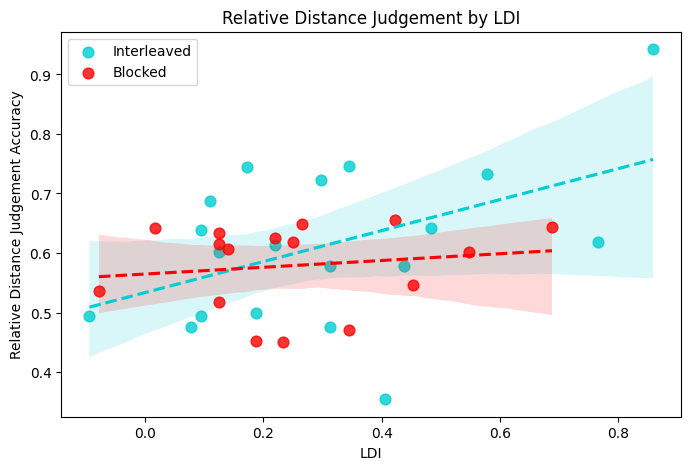

In [539]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.regplot(
    data=inter_accuracy,
    x="LDI",
    y="short_accuracy",
    scatter_kws={"s": 60, "color": "darkturquoise"},
    line_kws={"color": "darkturquoise","linestyle":"--"},
    label="Interleaved"
)
sns.regplot(
    data=blocked_accuracy,
    x="LDI",
    y="short_accuracy",
    scatter_kws={"s": 60, "color": "red"},
    line_kws={"color": "red","linestyle":"--"},
    label="Blocked"
)
plt.xlabel("LDI")
plt.ylabel("Relative Distance Judgement Accuracy")
plt.title("Relative Distance Judgement by LDI")
plt.legend()
plt.show()

In [515]:
from scipy.stats import pearsonr

# Interleaved group
r_inter, p_inter = pearsonr(inter_accuracy['LDI'], inter_accuracy['short_accuracy'])
print(f"Interleaved: r = {r_inter:.3f}, p = {p_inter:.3f}")

# Blocked group
r_blocked, p_blocked = pearsonr(blocked_accuracy['LDI'], blocked_accuracy['short_accuracy'])
print(f"Blocked: r = {r_blocked:.3f}, p = {p_blocked:.3f}")

Interleaved: r = 0.471, p = 0.042
Blocked: r = 0.155, p = 0.567


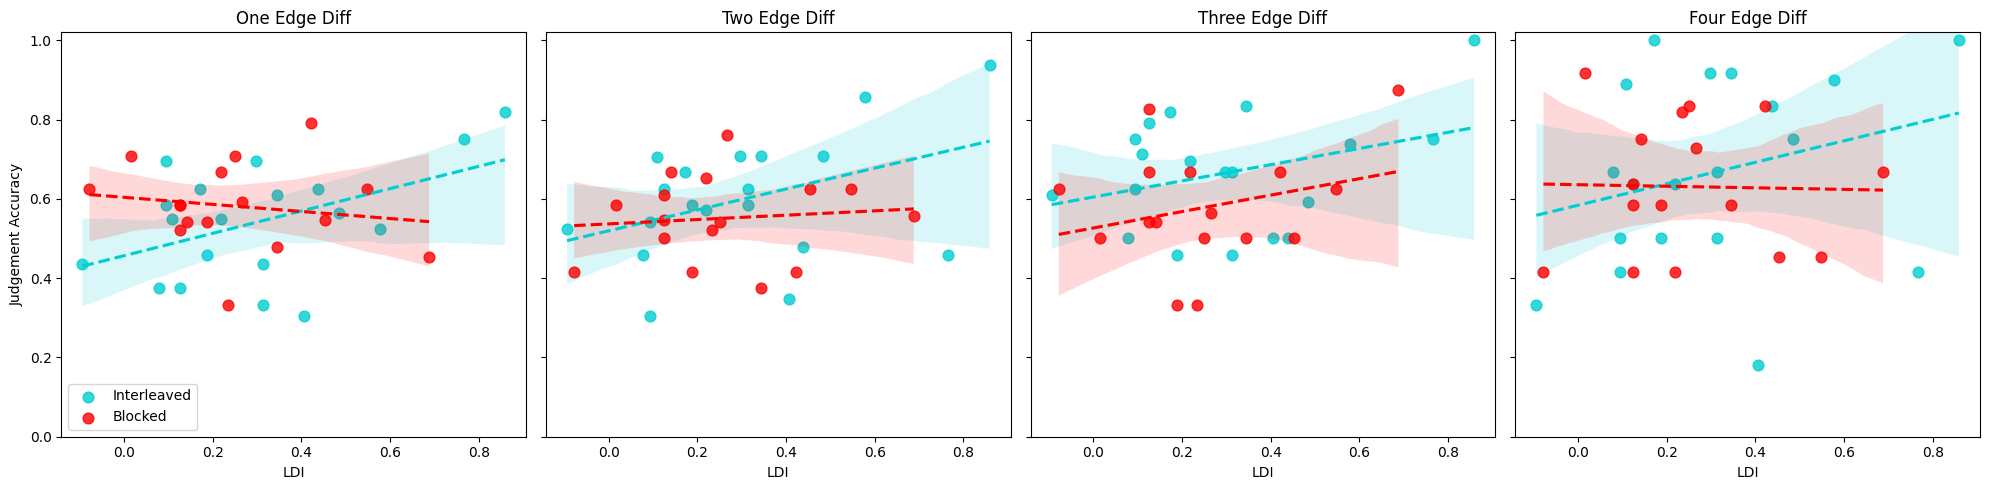

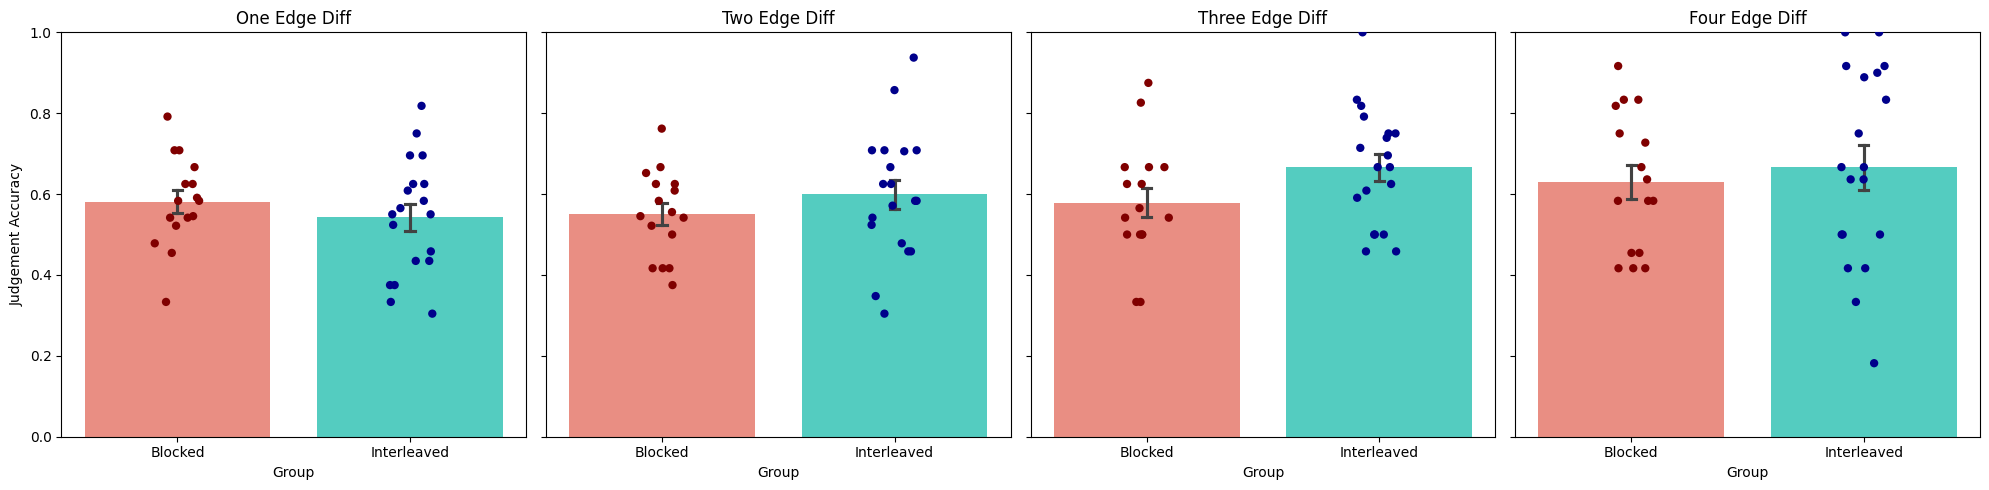

In [516]:
import seaborn as sns

one_dff_blocked = blocked_accuracy_conditions[blocked_accuracy_conditions['condition']=='One Edge Diff']
two_dff_blocked = blocked_accuracy_conditions[blocked_accuracy_conditions['condition']=='Two Edge Diff']
three_dff_blocked = blocked_accuracy_conditions[blocked_accuracy_conditions['condition']=='Three Edge Diff']
four_dff_blocked = blocked_accuracy_conditions[blocked_accuracy_conditions['condition']=='Four Edge Diff']

one_dff_inter = inter_accuracy_conditions[inter_accuracy_conditions['condition']=='One Edge Diff']
two_dff_inter = inter_accuracy_conditions[inter_accuracy_conditions['condition']=='Two Edge Diff']
three_dff_inter = inter_accuracy_conditions[inter_accuracy_conditions['condition']=='Three Edge Diff']
four_dff_inter = inter_accuracy_conditions[inter_accuracy_conditions['condition']=='Four Edge Diff']

# List of dataframes and titles
blocked_list = [one_dff_blocked, two_dff_blocked, three_dff_blocked, four_dff_blocked]
inter_list = [one_dff_inter, two_dff_inter, three_dff_inter, four_dff_inter]
titles = ["One Edge Diff", "Two Edge Diff", "Three Edge Diff", "Four Edge Diff"]

# Create 1 row x 4 columns of subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5), sharey=True)

for i, ax in enumerate(axes):
    # Plot interleaved
    sns.regplot(
        data=inter_list[i],
        x="LDI",
        y="short_accuracy",
        scatter_kws={"s": 60, "color": "darkturquoise"},
        line_kws={"color": "darkturquoise", "linestyle":"--"},
        ax=ax,
        label="Interleaved"
    )

    # Plot blocked
    sns.regplot(
        data=blocked_list[i],
        x="LDI",
        y="short_accuracy",
        scatter_kws={"s": 60, "color": "red"},
        line_kws={"color": "red", "linestyle":"--"},
        ax=ax,
        label="Blocked"
    )
    
    ax.set_title(titles[i])
    ax.set_xlabel("LDI")
    if i == 0:
        ax.set_ylabel("Judgement Accuracy")
        ax.legend(loc='lower left')
    else: 
        ax.set_ylabel("") 
    
    ax.set_ylim(0,1.02)
plt.tight_layout()
plt.show()

# List of dataframes and titles
blocked_list = [one_dff_blocked, two_dff_blocked, three_dff_blocked, four_dff_blocked]
inter_list = [one_dff_inter, two_dff_inter, three_dff_inter, four_dff_inter]
titles = ["One Edge Diff", "Two Edge Diff", "Three Edge Diff", "Four Edge Diff"]

# Create figure with 4 subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5), sharey=True)

for i, ax in enumerate(axes):
    # Combine blocked and inter data for this condition
    df_plot = pd.DataFrame({
        'Accuracy': np.concatenate([blocked_list[i]['short_accuracy'], inter_list[i]['short_accuracy']]),
        'Group': ['Blocked']*len(blocked_list[i]) + ['Interleaved']*len(inter_list[i])
    })
    
    # Overlay individual points
    sns.stripplot(
        data=df_plot,
        x='Group',
        hue='Group',
        y='Accuracy',
        palette=['maroon','darkblue'],
        size=6,
        jitter=True,
        ax=ax,
    )
    
    # Bar plot with mean + SEM
    sns.barplot(
        data=df_plot,
        x='Group',
        hue='Group',
        y='Accuracy',
        palette=['salmon','turquoise'],
        errorbar='se',
        capsize=0.04,
        ax=ax
    )

    ax.set_title(titles[i])
    if i == 0:
        ax.set_ylabel("Judgement Accuracy")
    ax.set_ylim(0,1)  # keep consistent scale

plt.tight_layout()
plt.show()

In [517]:
import pandas as pd
import statsmodels.formula.api as smf

# Combine your blocked and interleaved datasets
blocked_list = [one_dff_blocked, two_dff_blocked, three_dff_blocked, four_dff_blocked]
inter_list = [one_dff_inter, two_dff_inter, three_dff_inter, four_dff_inter]

# Concatenate all conditions
df_blocked = pd.concat(blocked_list, ignore_index=True)
df_blocked['Sequence'] = 'Blocked'

df_inter = pd.concat(inter_list, ignore_index=True)
df_inter['Sequence'] = 'Interleaved'

df = pd.concat([df_blocked, df_inter], ignore_index=True)

# Make sure categorical variables are properly coded
df['distDiff'] = df['condition'].astype('category')
df['Sequence'] = df['Sequence'].astype('category')
df['subject'] = df['partid'].astype('category')

# Fit mixed-effects model
model = smf.mixedlm(
    "short_accuracy ~ LDI * distDiff * Sequence",
    data=df,
    groups=df["subject"]  # random intercept for each participant
).fit()

print(model.summary())


                              Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             short_accuracy
No. Observations:               140                 Method:                         REML          
No. Groups:                     35                  Scale:                          0.0167        
Min. group size:                4                   Log-Likelihood:                 50.9624       
Max. group size:                4                   Converged:                      Yes           
Mean group size:                4.0                                                               
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

/Users/rohinpalsule/Downloads/cogs108/venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


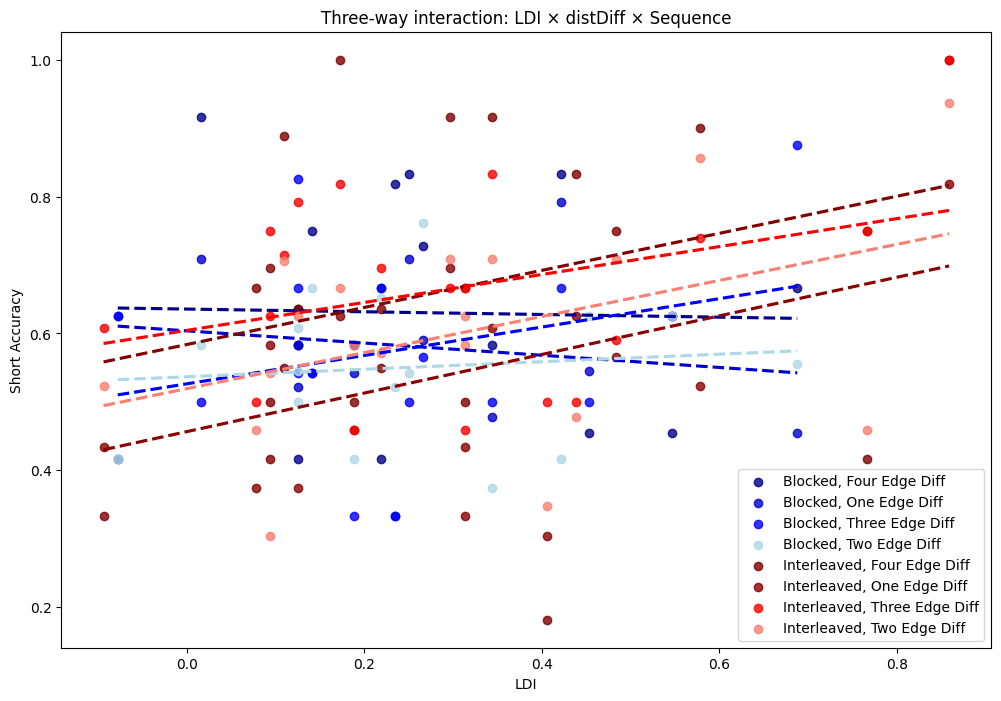

In [518]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(12,8))
# Generate predicted values for visualization
LDI_range = np.linspace(df['LDI'].min(), df['LDI'].max(), 50)
palette = ['darkblue','mediumblue','blue','lightblue','maroon','darkred','red','salmon']
for i,seq in enumerate(df['Sequence'].cat.categories):
    for j,diff in enumerate(df['distDiff'].cat.categories):
        subset = df[(df['Sequence']==seq) & (df['distDiff']==diff)]
        if len(subset) == 0:
            continue
        # Fit a simple linear model just for plotting
        sns.regplot(
            x='LDI',
            y='short_accuracy',
            data=subset,
            color = palette[j +i*4],
            label=f'{seq}, {diff}',
            line_kws={"linestyle":"--"},
            ci=None
        )

plt.xlabel('LDI')
plt.ylabel('Short Accuracy')
plt.title('Three-way interaction: LDI × distDiff × Sequence')
plt.legend()
plt.show()